# 6.1 Neutron star structure

In [1]:
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
import matplotlib.cm as cmap
from astropy import units, constants as const
from scipy.integrate import ode
import pandas as pd

## TOV equations

The TOV equations describe a spherically-symmetric ideal fluid in general-relativistic hydrostatic equilibrium. We can formulate them as two coupled ODEs for the pressure $p(r)$ and interior mass $m(r)$:

\begin{align}
\frac{\mathrm{d}p}{\mathrm{d}r}&=-\frac{\left(\rho + p\right)\left(m + 4\pi r^3 p\right)}{r\left(r - 2m\right)} \\
\frac{\mathrm{d}m}{\mathrm{d}r}&=4\pi r^2 \rho
\end{align}

To solve the TOV equations we have to specify an _equation of state (EOS)_ that relates pressure $p$ and density $\rho$, as well as boundary conditions at $r=0$. We require that $m(r=0)=0$ and choose a central density $\rho(r=0)=\rho_\mathrm{central}$.

In [2]:
def dp_dr(r, p, m, eos_rho):
    if r <= 0:
        return 0
    return -(eos_rho(p) + p) * (m + 4 * pi * r**3 * p) / r / (r - 2 * m)
def dm_dr(r, p, m, eos_rho):
    return 4 * pi * r**2 * eos_rho(p)
def tov_equations(r, p_and_m, eos_rho):
    return [
        dp_dr(r, *p_and_m, eos_rho),
        dm_dr(r, *p_and_m, eos_rho)
    ]

## Integration of the TOV equations

Given the EOS and boundary conditions, solving the TOV equations comes down to numerically integrating the two coupled ODEs from $r=0$ outwards. We stop the integration once the pressure vanishes, which defines the surface of the star:

In [3]:
def solve_tov_equations(p_central, eos_rho, step):
    r_initial = 0.
    p_and_m_initial = [ p_central, 0. ]
    
    integrator = ode(tov_equations).set_initial_value(p_and_m_initial, r_initial)
    integrator.set_f_params(eos_rho)
    integrator.set_integrator('dopri5')
    
    r_path = [ r_initial ]
    p_and_m_path = [ p_and_m_initial ]
    while integrator.successful():
        p_and_m = integrator.integrate(integrator.t + step)
        
        r_path.append(integrator.t)
        p_and_m_path.append(p_and_m)
        
        p, m = p_and_m
        if p <= 0:
            break

    r_path = np.asarray(r_path)
    p_and_m_path = np.asarray(p_and_m_path)
    return r_path, p_and_m_path[:,0], p_and_m_path[:,1]

## Setting up units

With these conversion factors to "geometric units" all quantities have units of length (in kilometers):

In [4]:
r_units = units.km
rho_units = const.c**2 / const.G / r_units**2
p_units = const.c**4 / const.G / r_units**2
m_units = const.c**2 / const.G * r_units

We can convert from and to SI units like this:

In [5]:
# A mass in SI units
test_mass = 1 * units.kg
test_mass

<Quantity 1. kg>

In [6]:
# The same mass in kilometers (geometric units):
test_mass_v = test_mass.to(m_units).value
test_mass_v

7.4259154861063354e-31

In [7]:
# Convert back to SI units...
test_mass_v * m_units.si

<Quantity 1. kg>

In [8]:
# ...or CGS units:
test_mass_v * m_units.cgs

<Quantity 1000. g>

## A simple polytropic EOS

Around nuclear density $\rho_\mathrm{nuclear}\approx2.3\times 10^{17}\frac{\mathrm{kg}}{\mathrm{m^3}}$ we can approximate some models for the equation of state within a neutron star with a simple _polytrope_:

\begin{equation}
p(\rho) = 3\times 10^{32} \left(\frac{\rho}{\rho_\mathrm{nuclear}}\right)^3 \frac{\mathrm{N}}{\mathrm{m}^2}
\end{equation}

In [9]:
rho_nuclear = 2.3e17 * units.kg / units.m**3
rho_nuclear_v = rho_nuclear.to(rho_units).value

In [10]:
p_nuclear = 3e32 * units.N / units.m**2
p_nuclear_v = p_nuclear.to(p_units).value
# We provide both p(rho) and its inverse rho(p)
def eos_rho_simple(p):
    return (p / p_nuclear_v)**(1/3) * rho_nuclear_v
def eos_p_simple(rho):
    return (rho / rho_nuclear_v)**3 * p_nuclear_v

With the EOS specified we can now solve the TOV equations for any central density $\rho_\mathrm{central}$ to obtain the pressure and interior mass profile within the neutron star. Furthermore, we obtain the radius $R$ of the neutron star (which is where the pressure vanishes and we stopped the integration), as well as its mass $M=m(R)$:

/Users/nlf/.virtualenvs/scientific/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """
/Users/nlf/.virtualenvs/scientific/lib/python3.7/site-packages/scipy/integrate/_ode.py:1177: UserWarning: dopri5: step size becomes too small
  self.messages.get(istate, unexpected_istate_msg)))


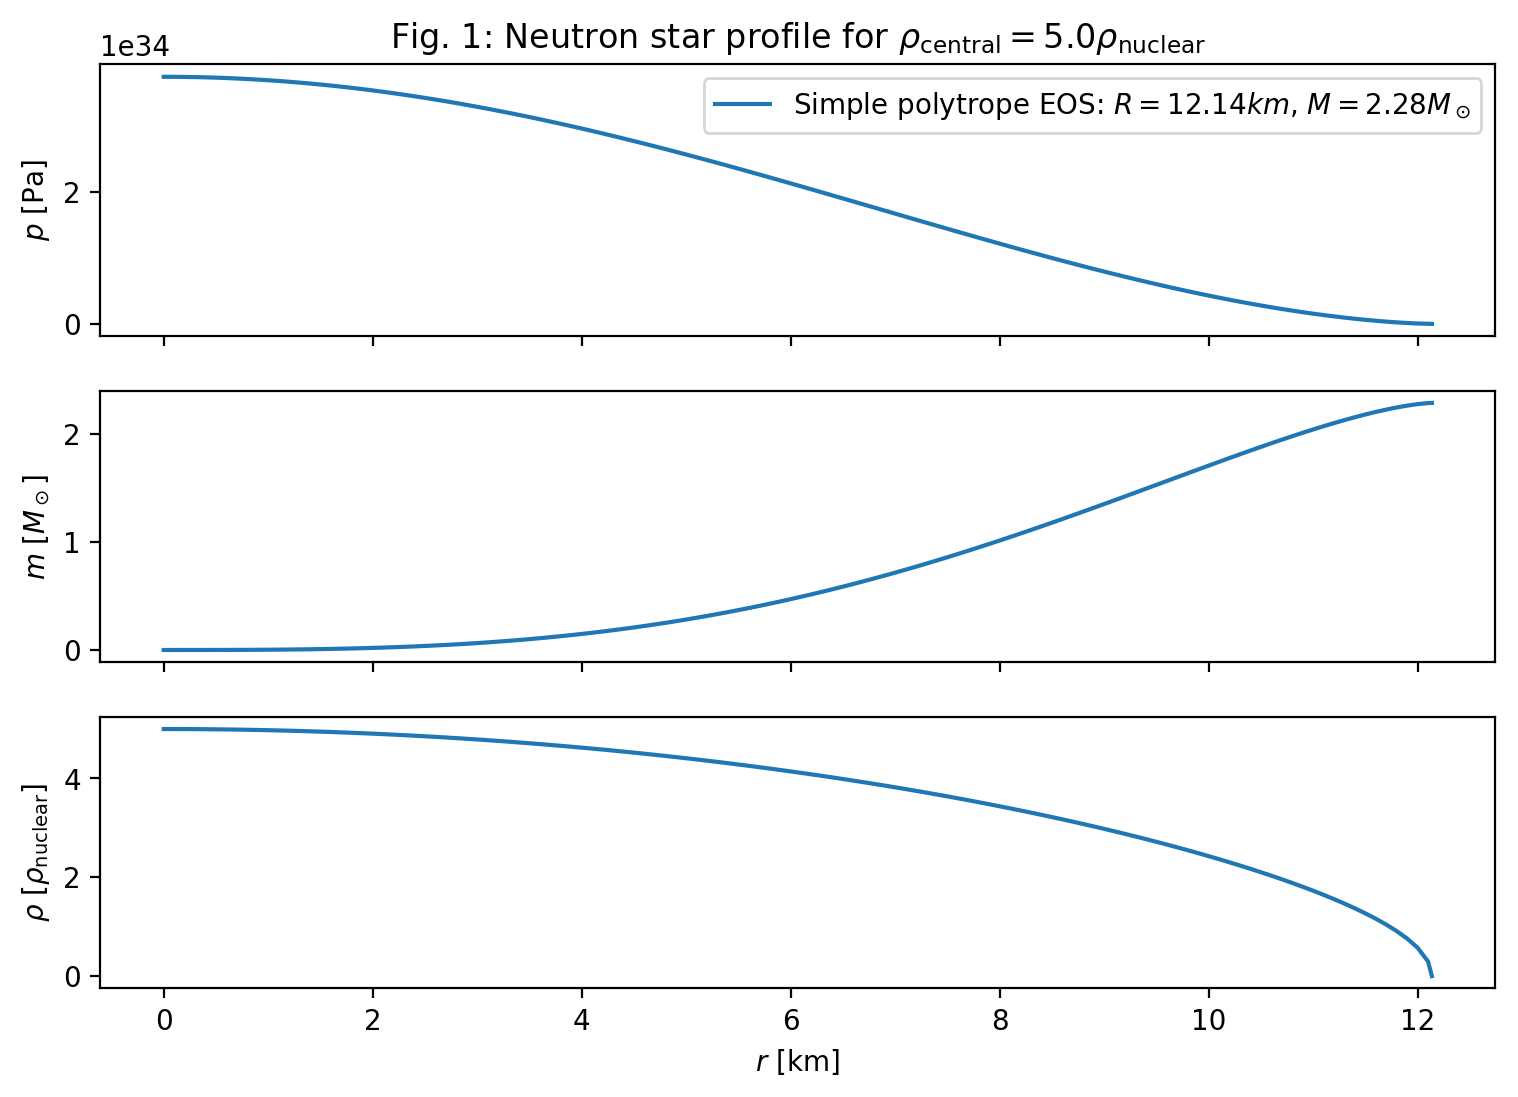

In [11]:
rho_central = 5 * rho_nuclear_v
p_central = eos_p_simple(rho_central)
r, p, m = solve_tov_equations(p_central=p_central, eos_rho=eos_rho_simple, step=0.1)
rho = eos_rho_simple(p) / rho_nuclear_v
# Add units to the quantities
r = r * r_units
p = p * p_units
m = m * m_units
# The radius of the neutron star
R = r[-1]
# The mass of the neutron star
M = m[-1]

fig, axes = plt.subplots(figsize=(9, 6), nrows=3, sharex=True)
plt.sca(axes[0])
plt.title(r"Fig. 1: Neutron star profile for $\rho_\mathrm{central}=" + "{:.1f}".format(rho_central / rho_nuclear_v) +  r"\rho_\mathrm{nuclear}$")
plt.plot(r.to(units.km), p.to(units.pascal), label="Simple polytrope EOS: $R={:.2f}".format(R) + r"$, $M=" + "{:.2f}".format(M.si / const.M_sun)+ r"M_\odot$")
plt.ylabel("$p$ [{}]".format(units.pascal.to_string('latex_inline')))
plt.legend()
plt.sca(axes[1])
plt.plot(r.to(units.km), m.si / const.M_sun)
plt.ylabel("$m$ [$M_\odot$]")
plt.sca(axes[2])
plt.plot(r.to(units.km), rho)
plt.ylabel(r"$\rho$ [$\rho_\mathrm{nuclear}$]")
plt.xlabel("$r$ [{}]".format(units.km.to_string('latex_inline')));

By varying the central density of a neutron star with the given EOS, we obtain possible values for its radius and mass:

In [12]:
def sample_eos_mass_radius(eos_p, eos_rho, rho_central_start=2 * rho_nuclear_v, rho_central_log_step=0.05, rho_central_stop=20 * rho_nuclear_v, stop_at_maximum_mass=False):
    MR_data = pd.DataFrame(columns=['rho_central', 'M', 'R']).set_index('rho_central')
    rho_central = rho_central_start
    while rho_central < rho_central_stop:
        p_central = eos_p(rho_central)
        r, p, m = solve_tov_equations(p_central=p_central, eos_rho=eos_rho, step=0.1)
        R = r[-1]
        M = m[-1] * m_units.si / const.M_sun
        if stop_at_maximum_mass and len(MR_data) > 0 and M < MR_data['M'].iat[-1]:
            break
        MR_data.loc[rho_central] = [M, R]
        rho_central += rho_central * rho_central_log_step
    return MR_data

In [13]:
simple_eos_data = {
    'Simple polytropic EOS': sample_eos_mass_radius(eos_p_simple, eos_rho_simple, rho_central_start=5 * rho_nuclear_v)
}

/Users/nlf/.virtualenvs/scientific/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


In [14]:
def plot_eos_data(eos_data, fig_i):
    fig, axes = plt.subplots(figsize=(8, 5), nrows=2, ncols=1, sharex=True)
    for eos_name, MR_data in eos_data.items():
        rho_in_rho_nuclear = MR_data.index / rho_nuclear_v
        axes[0].plot(rho_in_rho_nuclear, MR_data['R'], label=eos_name, marker='.')
        axes[0].set_ylabel("$R$ [km]")
        axes[0].legend()
        axes[1].plot(rho_in_rho_nuclear, MR_data['M'], marker='.')
        axes[1].set_xlabel(r"$\rho_\mathrm{central}$ [$\rho_\mathrm{nuclear}$]")
        axes[1].set_ylabel("$M$ [$M_\odot$]")
    axes[0].set_title("Fig. {}: Neutron star radii and masses".format(fig_i))
    fig.tight_layout()

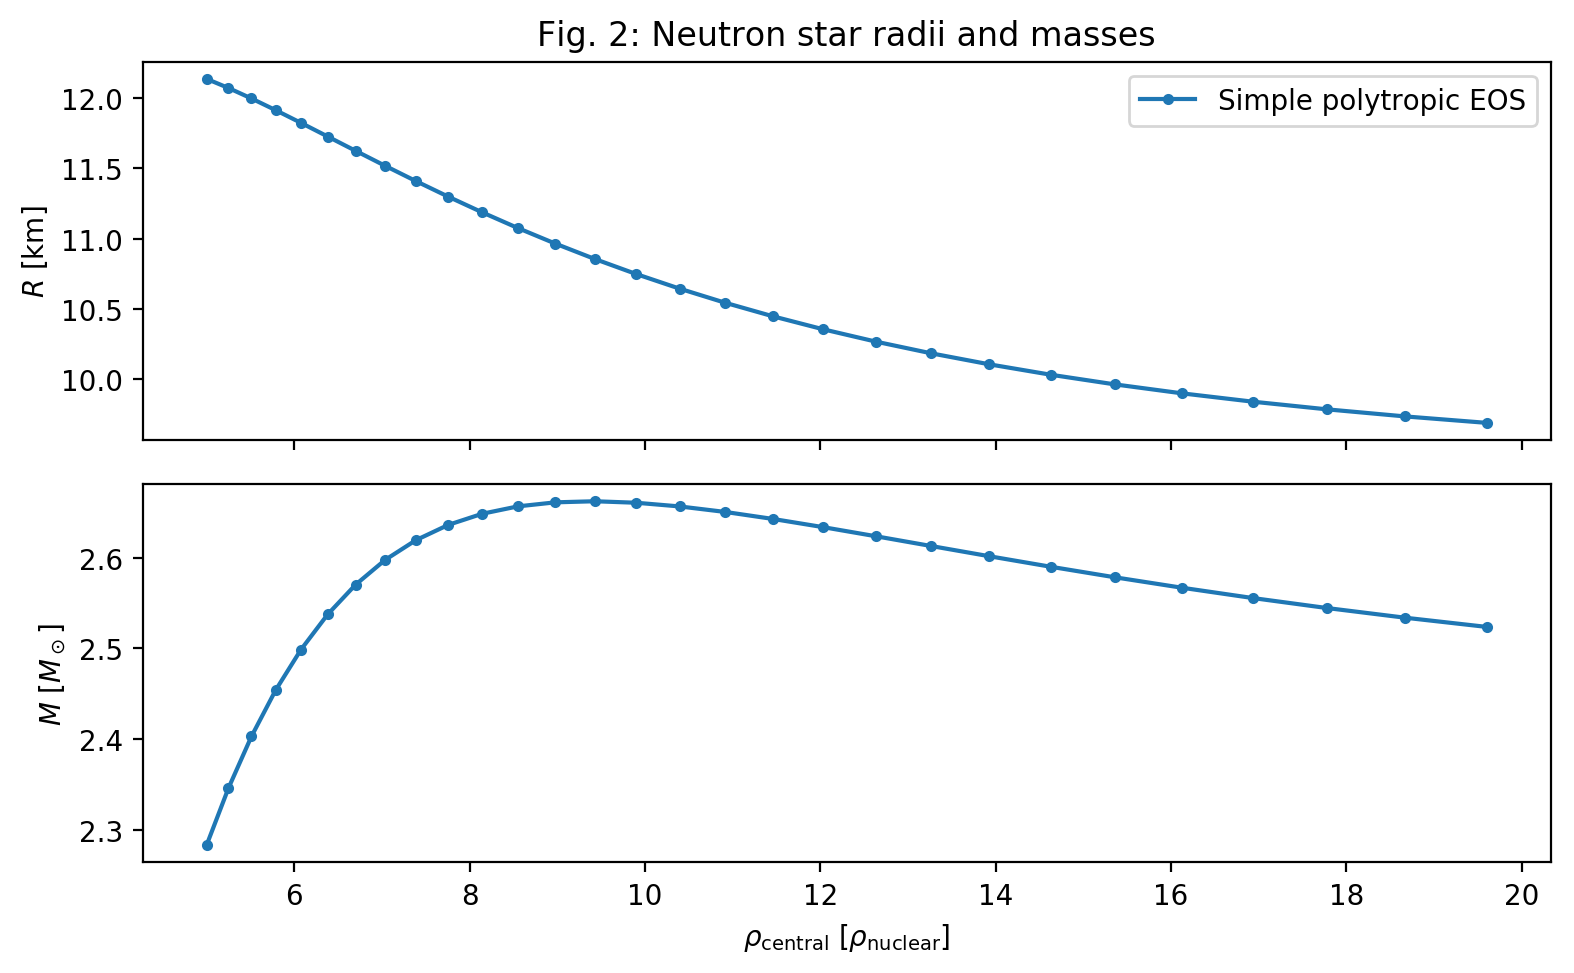

In [15]:
plot_eos_data(simple_eos_data, fig_i=2)

In [16]:
def plot_mass_radius(eos_data, fig_i):
    for eos_name, MR_data in eos_data.items():
        plt.plot(MR_data['R'], MR_data['M'], label=eos_name, marker='.')
    xrange = (8, 15)
    yrange = (0.2, 2.8)
    plt.xlabel("$R$ [km]")
    plt.ylabel("$M$ [$M_\odot$]")
    plt.title("Fig. {}: Neutron star mass-radius relation".format(fig_i))
    plt.legend();

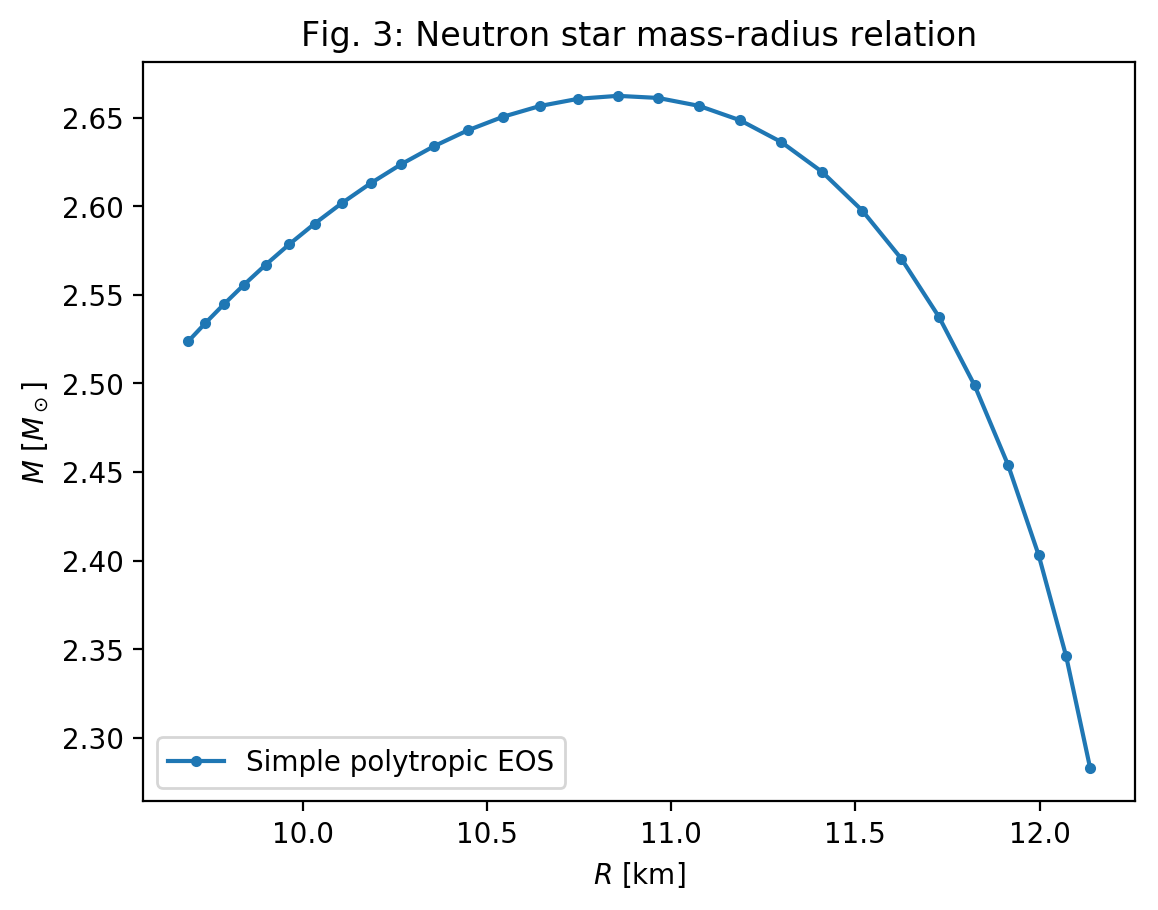

In [17]:
plot_mass_radius(simple_eos_data, fig_i=3)

## EOS for a multi-layered neutron star

A better model for the neutron star EOS is a series of polytropes

\begin{equation}
p_i(\rho) = K_i \rho^\Gamma_i
\end{equation}

where each is valid for a particular density interval. Following [[1]](https://arxiv.org/pdf/0812.2163.pdf) we begin with $\Gamma_0=1.33$ at sub-nuclear densities that occur in the neutron star crust (taken from [[2]](https://arxiv.org/pdf/astro-ph/0111092.pdf)). We then parametrize three layers of the neutron star core that are divided at densities $\rho_1=10^{14.7}\frac{\mathrm{g}}{\mathrm{cm^3}}$ and $\rho_2=10^{15}\frac{\mathrm{g}}{\mathrm{cm^3}}$ with the pressure $p_1$ at density $\rho_1$ and the three adiabatic indices $\Gamma_1$, $\Gamma_2$ and $\Gamma_3$:

In [18]:
# Low-density adiabatic index
gamma0 = 1.33
# Density where the neutron star core begins
rho0 = rho_nuclear
# Densities that divide the neutron star core into three layers
rho1 = 10**14.7 * units.g / units.cm**3
rho2 = 10**15 * units.g / units.cm**3

rho0_v = rho0.to(rho_units).value
rho1_v = rho1.to(rho_units).value
rho2_v = rho2.to(rho_units).value
def eos_p_polytropic(rho, p1, gamma1, gamma2, gamma3):
    global gamma0, rho0_v, rho1_v, rho2_v
    p0 = p1 * (rho0_v / rho1_v)**gamma1
    p2 = p1 * (rho2_v / rho1_v)**gamma2
    return np.piecewise(rho, [
        rho < rho0_v,
        np.logical_and(rho >= rho0_v, rho < rho1_v),
        np.logical_and(rho >= rho1_v, rho < rho2_v),
        rho >= rho2_v
    ], [
        lambda rho: p0 * (rho / rho0_v)**gamma0,
        lambda rho: p1 * (rho / rho1_v)**gamma1,
        lambda rho: p1 * (rho / rho1_v)**gamma2,
        lambda rho: p2 * (rho / rho2_v)**gamma3
    ])
def eos_rho_polytropic(p, p1, gamma1, gamma2, gamma3):
    global gamma0, rho0_v, rho1_v, rho2_v
    p0 = p1 * (rho0_v / rho1_v)**gamma1
    p2 = p1 * (rho2_v / rho1_v)**gamma2
    return np.piecewise(p, [
        p < p0,
        np.logical_and(p >= p0, p < p1),
        np.logical_and(p >= p1, p < p2),
        p >= p2
    ], [
        lambda p: (p / p0)**(1 / gamma0) * rho0_v,
        lambda p: (p / p1)**(1 / gamma1) * rho1_v,
        lambda p: (p / p1)**(1 / gamma2) * rho1_v,
        lambda p: (p / p2)**(1 / gamma3) * rho2_v
    ])

Table III in [[1]](https://arxiv.org/pdf/0812.2163.pdf) provides best-fit values for the parameters $p_1$, $\Gamma_1$, $\Gamma_2$ and $\Gamma_3$ to many EOS models from nuclear physics. We choose a few EOS from that list:

In [19]:
polytropes = {
    'SLy': {
        'p1': 10**34.384 * units.dyne / units.cm**2,
        'gamma1': 3.005,
        'gamma2': 2.988,
        'gamma3': 2.851
    },
    'GS1': {
        'p1': 10**34.504 * units.dyne / units.cm**2,
        'gamma1': 2.350,
        'gamma2': 1.267,
        'gamma3': 2.421,
    },
    # ...
}

In [20]:
# Create an EOS function that uses the parameters
def make_polytrope_eos_p_and_rho(name):
    params = polytropes[name]
    p1 = params['p1'].to(p_units).value
    gammas = [params['gamma1'], params['gamma2'], params['gamma3']]
    return (
        lambda rho: eos_p_polytropic(rho, p1, *gammas),
        lambda p: eos_rho_polytropic(p, p1, *gammas),
    )

In [21]:
# Make a list of all EOS that we want to test
eos_list_p_and_rho = [
    ('Simple', eos_p_simple, eos_rho_simple)
] + [ (name,) + make_polytrope_eos_p_and_rho(name) for name in polytropes ]

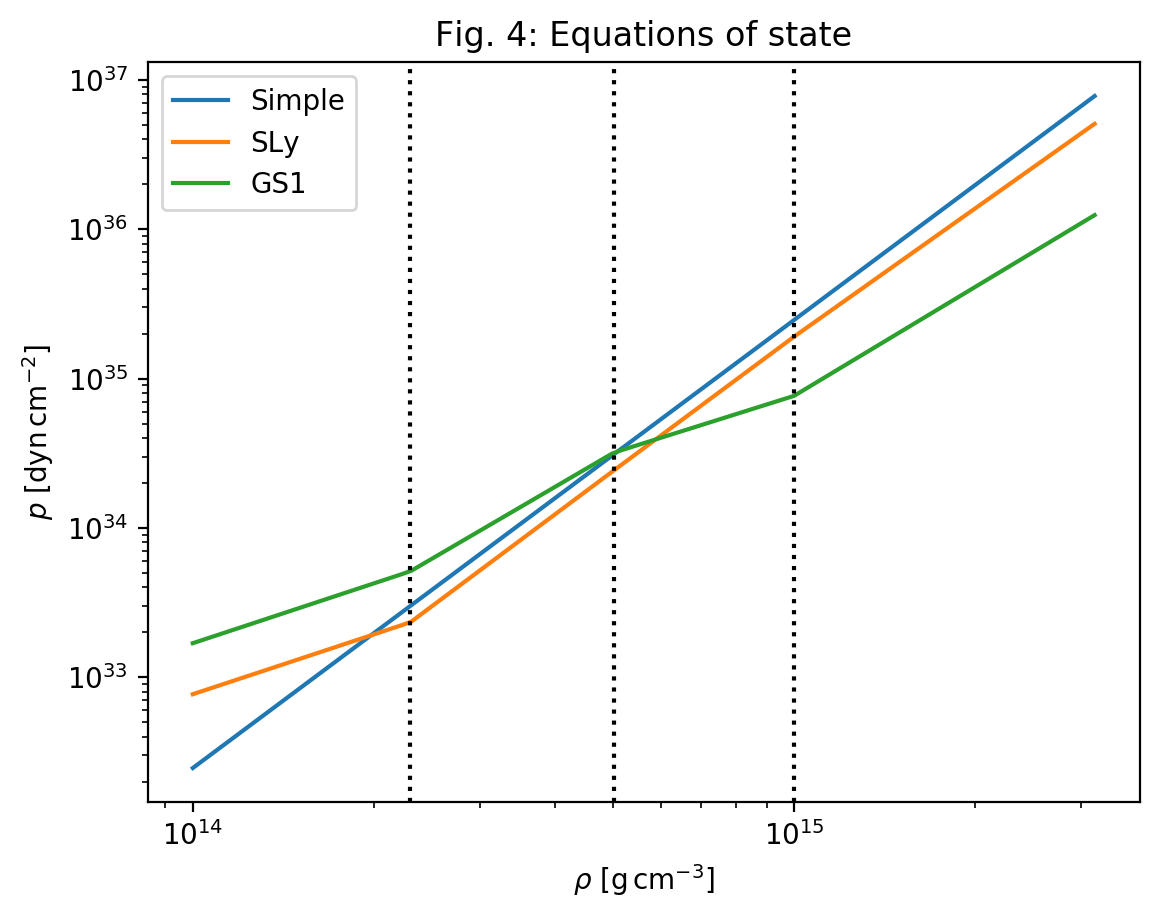

In [22]:
# Plot all EOS
rho_space = np.logspace(14, 15.5, 100) * units.g / units.cm**3
rho_space_v = rho_space.to(rho_units).value
p_units_v = p_units.to(units.dyne / units.cm**2)

for name, eos_p, _ in eos_list_p_and_rho:
    plt.loglog(rho_space, eos_p(rho_space_v) * p_units_v, label=name)

plt.title("Fig. 4: Equations of state")
plt.axvline(rho_nuclear.to(units.g / units.cm**3).value, color='black', ls='dotted')
plt.axvline(rho1.to(units.g / units.cm**3).value, color='black', ls='dotted')
plt.axvline(rho2.to(units.g / units.cm**3).value, color='black', ls='dotted')
plt.xlabel(r"$\rho$ [{}]".format((units.g / units.cm**3).to_string('latex_inline')))
plt.ylabel(r"$p$ [{}]".format((units.dyne / units.cm**2).to_string('latex_inline')))
plt.legend();

We can now analyse the neutron star mass-radius relation for the multi-layered EOS:

**Note: Here, we stop going to larger $\rho_\mathrm{central}$ once we reach a maximum in the mass $M(\rho_\mathrm{central})$.**

In [23]:
# This may take a few minutes
eos_data = dict([
    (eos_name, sample_eos_mass_radius(eos_p, eos_rho, stop_at_maximum_mass=True)) for eos_name, eos_p, eos_rho in eos_list_p_and_rho
])

/Users/nlf/.virtualenvs/scientific/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """
/Users/nlf/.virtualenvs/scientific/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in power


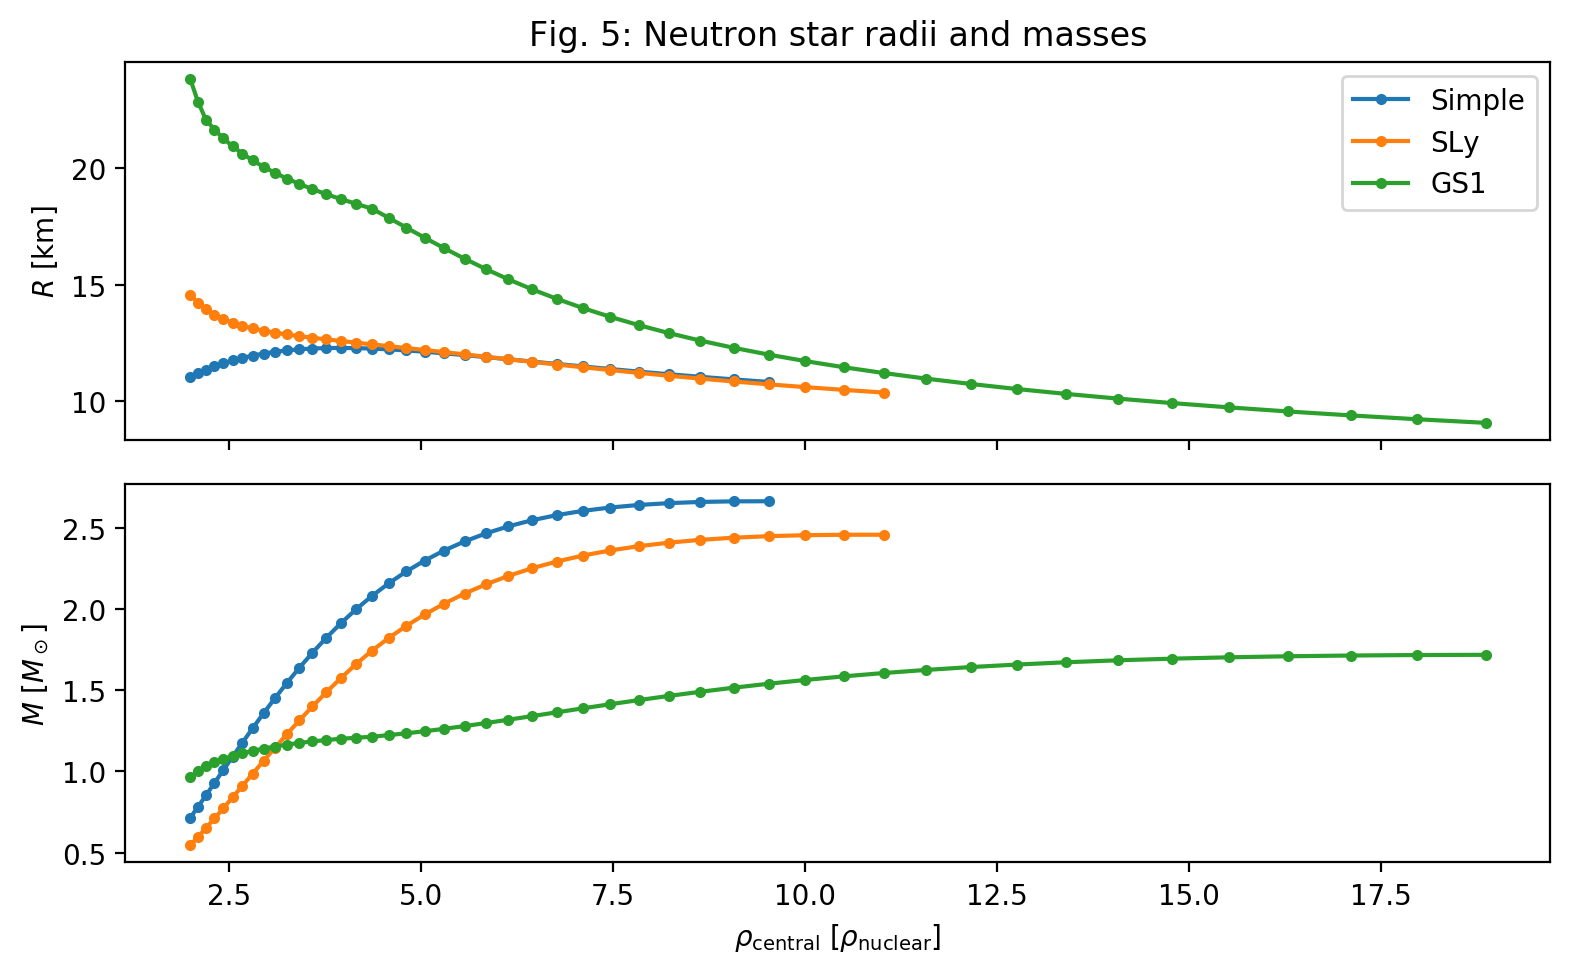

In [24]:
plot_eos_data(eos_data, fig_i=5)

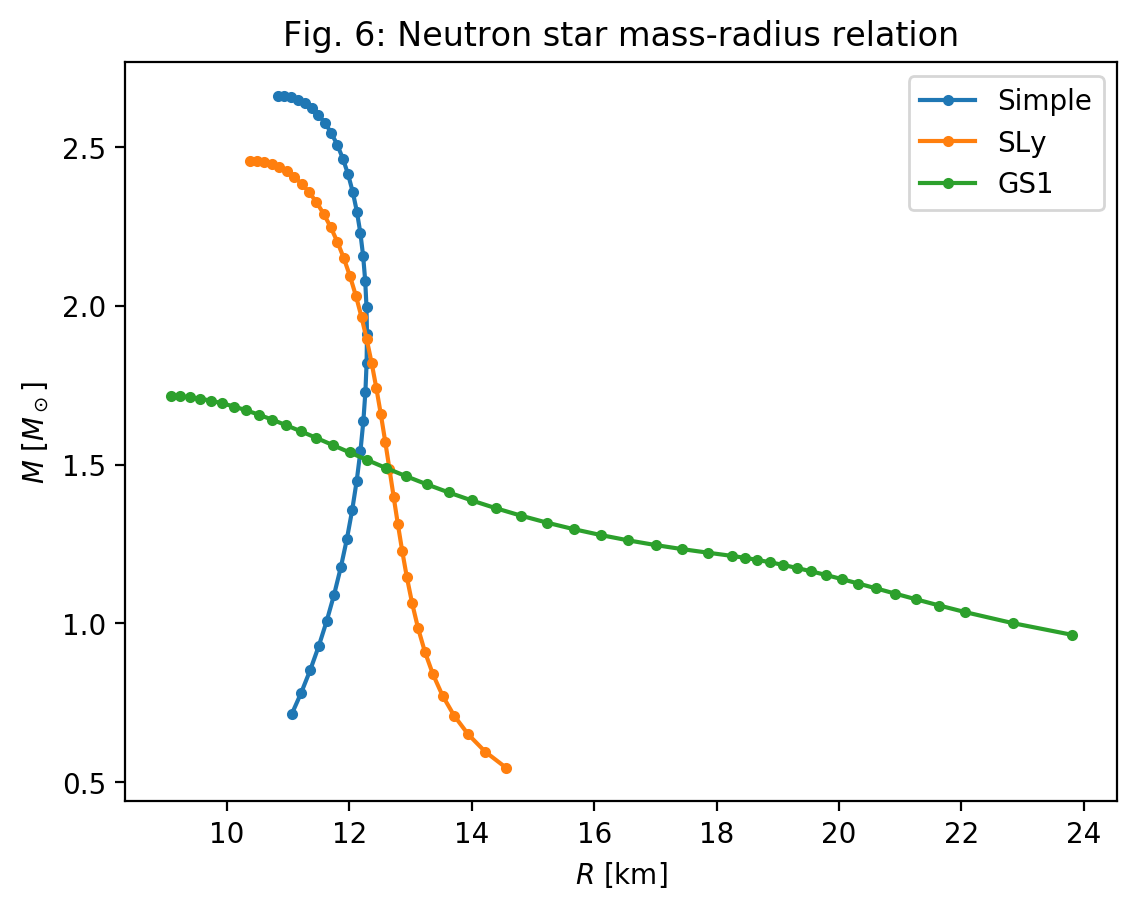

In [25]:
plot_mass_radius(eos_data, fig_i=6)

Finally, we can use the first observation of a binary neutron star merger GW170817 to constrain the equation of state of nuclear matter. We use the data from Figure 3 (left panel) of the LIGO paper [[3]](https://arxiv.org/abs/1805.11581) to get an idea of the masses and radii of the two observed neutron stars and compare them to the possible masses and radii for each EOS:

In [26]:
M1_data, M2_data, R1_data, R2_data = np.loadtxt('EoS-insensitive_posterior_samples.dat', unpack=True, usecols=[0, 1, 4, 5])

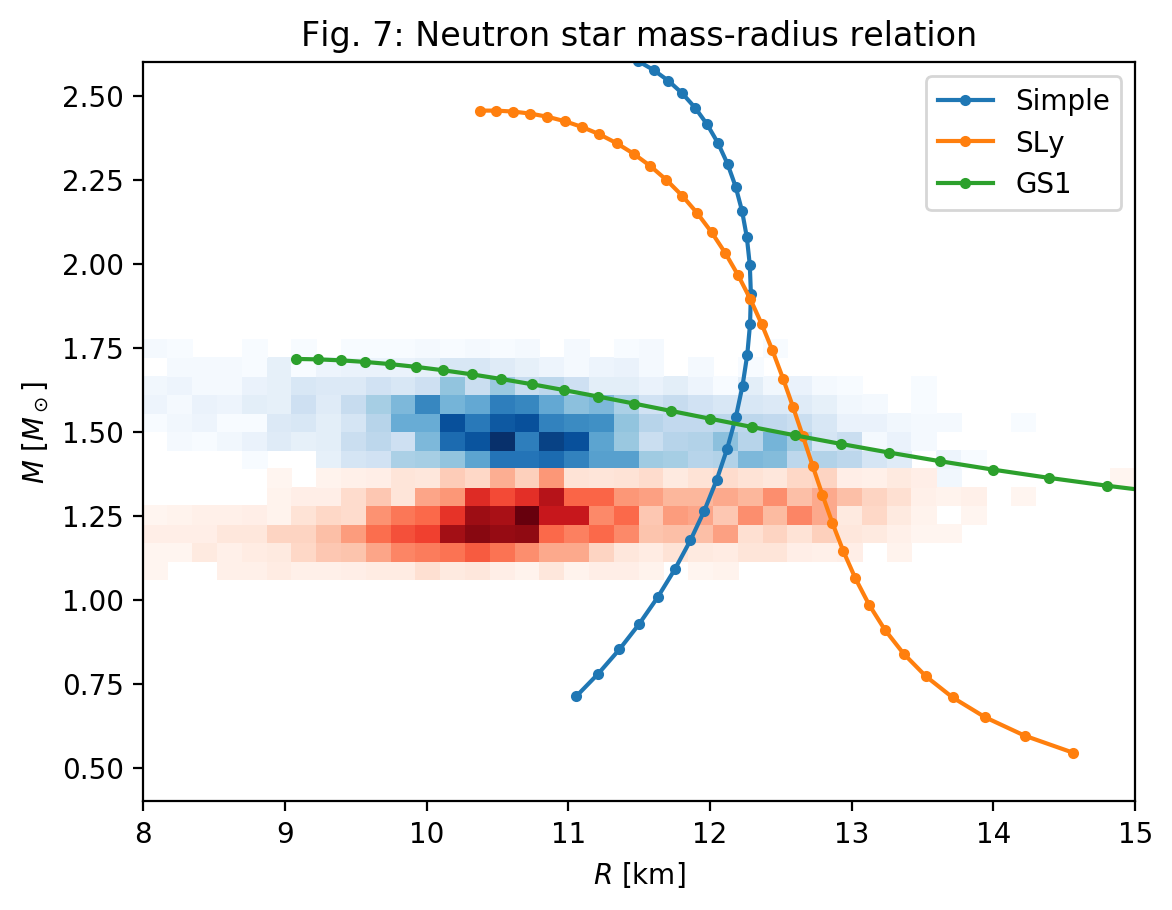

In [27]:
xrange = (8, 15)
yrange = (0.4, 2.6)
plt.hist2d(R1_data, M1_data, bins=40, cmap=cmap.Blues, range=(xrange, yrange), cmin=1);
plt.hist2d(R2_data, M2_data, bins=40, cmap=cmap.Reds, range=(xrange, yrange), cmin=1);
plot_mass_radius(eos_data, fig_i=7)
plt.xlim(*xrange)
plt.ylim(*yrange);